In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import redditutils as ru
import word2vecReader as wvr

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import recall_score

from skopt import BayesSearchCV


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [289]:
# include below until https://github.com/scikit-optimize/scikit-optimize/issues/718 is resolved
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [256]:
df = pd.read_csv('cleaned_shower.csv', index_col = 0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [259]:
df['quality'] = df['score'].apply(lambda x: ru.make_labels(x))

In [262]:
df.to_csv('shower_clean.csv')

## Train test split

In [263]:
df = df[df['title'].notna()]

In [265]:
X = df['title']
y = df['quality']

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 2325)

In [277]:
X_train_short = X_train[:100000]
y_train_short = y_train[:100000]

In [323]:
X_test_short = X_test[:100000]
y_test_short = y_test[:100000]

In [278]:
X_train_shorter = X_train[:5000]
y_train_shorter = y_train[:5000]

In [279]:
X_test_shorter = X_test[:2500]
y_test_shorter = y_test[:2500]

In [473]:
df[df['quality'] == 1].sample(20)

,title,score,id,created_utc,selftext,num_comments,quality
414990,successful today marketing disguise,7.0,9ctk3b,2018-09-04 07:53:30,Down with the hype!,0.0,1
845055,good morning good evening good night always fa...,12.0,83yz7k,2018-03-12 22:02:29,NaN,4.0,1
881261,human hair man made natural,22.0,4xhwj9,2016-08-13 06:09:01,NaN,5.0,1
735813,closer collapse berlin wall today,38.0,7sh1f5,2018-01-23 19:37:58,NaN,2.0,1
895155,proper sex,3.0,4vtnbn,2016-08-02 17:27:19,"In English, you never say you ""sex"" someone, y...",6.0,1
592946,cant handle worst dont deserve best actually s...,3.0,50ahlk,2016-08-30 10:44:55,NaN,1.0,1
791184,invent shovel make relevant digs golden buried...,8.0,438lmj,2016-01-29 12:31:03,[deleted],3.0,1
957604,funny courtroom one popular form entertainment...,136.0,4xv5wb,2016-08-15 18:54:25,[removed],11.0,1
377936,come people always brush teeth without,2.0,7r0woq,2018-01-17 13:21:29,[deleted],0.0,1
720155,today especially hard people deliver bad news,7.0,62tgex,2017-04-01 15:41:51,NaN,2.0,1


## Word embedding with word2vec

In [270]:
model_path = "./word2vec_twitter_model.bin"
model = KeyedVectors.load_word2vec_format(model_path, binary=True, unicode_errors='ignore')

In [387]:
model.save('word2vec_mod.pkl')

In [392]:
def make_features(words, model, num_features):
    features = np.zeros(num_features)
    
    model_vocab = set(model.index2word)
    
    num_words = 0
    
    # Loop over words in documents. If the word is in model's vocabulary,
    # generate its feature vector
    for w in words:
        if w in model_vocab:
            num_words += 1
            features = np.add(features, model[w])
            
    # Normalize the feature vector
    features = np.divide(features, num_words)
    
    return features

In [395]:
def document_vecs(docs, model, num_features):
    # Get the average feature vector for each showerthought based on the words it's comprised of
    counter = 0
    
    doc_vector = np.zeros((len(docs), num_features))
    
    for d in docs:
        if counter%100 == 0:
            print(f'Finished document number {counter}')
            
        # Add this document's feature vector to doc_vector
        doc_vector[counter] = make_features(d.split(' '), model, num_features)
            
        counter += 1
    return doc_vector

In [398]:
features_new_train = document_vecs(X_train_short, model, 400)

Finished document number 0
Finished document number 100
Finished document number 200
Finished document number 300
Finished document number 400
Finished document number 500
Finished document number 600
Finished document number 700
Finished document number 800
Finished document number 900
Finished document number 1000
Finished document number 1100
Finished document number 1200
Finished document number 1300
Finished document number 1400
Finished document number 1500
Finished document number 1600
Finished document number 1700
Finished document number 1800
Finished document number 1900
Finished document number 2000
Finished document number 2100
Finished document number 2200
Finished document number 2300
Finished document number 2400
Finished document number 2500
Finished document number 2600
Finished document number 2700
Finished document number 2800
Finished document number 2900
Finished document number 3000
Finished document number 3100
Finished document number 3200
Finished document numb

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Finished document number 14400
Finished document number 14500
Finished document number 14600
Finished document number 14700
Finished document number 14800
Finished document number 14900
Finished document number 15000
Finished document number 15100
Finished document number 15200
Finished document number 15300
Finished document number 15400
Finished document number 15500
Finished document number 15600
Finished document number 15700
Finished document number 15800
Finished document number 15900
Finished document number 16000
Finished document number 16100
Finished document number 16200
Finished document number 16300
Finished document number 16400
Finished document number 16500
Finished document number 16600
Finished document number 16700
Finished document number 16800
Finished document number 16900
Finished document number 17000
Finished document number 17100
Finished document number 17200
Finished document number 17300
Finished document number 17400
Finished document number 17500
Finished

Finished document number 40900
Finished document number 41000
Finished document number 41100
Finished document number 41200
Finished document number 41300
Finished document number 41400
Finished document number 41500
Finished document number 41600
Finished document number 41700
Finished document number 41800
Finished document number 41900
Finished document number 42000
Finished document number 42100
Finished document number 42200
Finished document number 42300
Finished document number 42400
Finished document number 42500
Finished document number 42600
Finished document number 42700
Finished document number 42800
Finished document number 42900
Finished document number 43000
Finished document number 43100
Finished document number 43200
Finished document number 43300
Finished document number 43400
Finished document number 43500
Finished document number 43600
Finished document number 43700
Finished document number 43800
Finished document number 43900
Finished document number 44000
Finished

Finished document number 67400
Finished document number 67500
Finished document number 67600
Finished document number 67700
Finished document number 67800
Finished document number 67900
Finished document number 68000
Finished document number 68100
Finished document number 68200
Finished document number 68300
Finished document number 68400
Finished document number 68500
Finished document number 68600
Finished document number 68700
Finished document number 68800
Finished document number 68900
Finished document number 69000
Finished document number 69100
Finished document number 69200
Finished document number 69300
Finished document number 69400
Finished document number 69500
Finished document number 69600
Finished document number 69700
Finished document number 69800
Finished document number 69900
Finished document number 70000
Finished document number 70100
Finished document number 70200
Finished document number 70300
Finished document number 70400
Finished document number 70500
Finished

Finished document number 93900
Finished document number 94000
Finished document number 94100
Finished document number 94200
Finished document number 94300
Finished document number 94400
Finished document number 94500
Finished document number 94600
Finished document number 94700
Finished document number 94800
Finished document number 94900
Finished document number 95000
Finished document number 95100
Finished document number 95200
Finished document number 95300
Finished document number 95400
Finished document number 95500
Finished document number 95600
Finished document number 95700
Finished document number 95800
Finished document number 95900
Finished document number 96000
Finished document number 96100
Finished document number 96200
Finished document number 96300
Finished document number 96400
Finished document number 96500
Finished document number 96600
Finished document number 96700
Finished document number 96800
Finished document number 96900
Finished document number 97000
Finished

In [399]:
pickle.dump(features_new_train, open('fixed_100k_train.pkl', 'wb'))

array([[ 0.14314658,  0.12411304, -0.10359381, ...,  0.02417248,
         0.10256661,  0.12569072],
       [ 0.28753818, -0.03790128,  0.02485482, ..., -0.00836292,
         0.16453008, -0.06691376],
       [ 0.04877502, -0.09626516, -0.03996636, ..., -0.02428033,
         0.11233017, -0.08152764],
       ...,
       [ 0.17443486, -0.06474438,  0.08749882, ..., -0.00729547,
         0.02567547, -0.02175013],
       [ 0.15424998,  0.02614269,  0.01940249, ...,  0.08097694,
         0.20957238, -0.1983384 ],
       [ 0.00191166,  0.00628826, -0.01364556, ...,  0.19209208,
         0.25373289,  0.05674959]])

In [ ]:
features_new_test = document_vecs(X_test_short, model, 400)

In [81]:
features_test = document_vecs(X_test_shorter, model, 400)

Finished document number 0
Finished document number 100
Finished document number 200
Finished document number 300
Finished document number 400
Finished document number 500
Finished document number 600
Finished document number 700
Finished document number 800
Finished document number 900
Finished document number 1000
Finished document number 1100
Finished document number 1200
Finished document number 1300
Finished document number 1400
Finished document number 1500
Finished document number 1600
Finished document number 1700
Finished document number 1800
Finished document number 1900
Finished document number 2000
Finished document number 2100
Finished document number 2200
Finished document number 2300
Finished document number 2400


In [280]:
features_train = document_vecs(X_train_shorter[:1000], model, 400)

Finished document number 0
Finished document number 100
Finished document number 200
Finished document number 300
Finished document number 400
Finished document number 500
Finished document number 600
Finished document number 700
Finished document number 800
Finished document number 900


In [281]:
response_train = y_train[:1000]

[autoreload of redditutils failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/luketibbott/Documents/Metis/project_fletcher/redditutils.py", line 10, in <module>
    from imblearn import SMOTE as sm
ImportError: cannot import name 'SMOTE'
]


In [403]:
def remove_bad_indices(features, response):
    # Remove document-response pairs that failed to be embedded in vector space
    bad_indices = list(np.unique(np.where(np.isnan(features)[0])))
    
    features = np.delete(features, bad_indices, axis=0)
    response = np.delete(np.array(response), bad_indices)
    
    return features, response

In [325]:
one_hunnid_train = document_vecs(X_train_short, model, 400)

Finished document number 0
Finished document number 100
Finished document number 200
Finished document number 300
Finished document number 400
Finished document number 500
Finished document number 600
Finished document number 700
Finished document number 800
Finished document number 900
Finished document number 1000
Finished document number 1100
Finished document number 1200
Finished document number 1300
Finished document number 1400
Finished document number 1500
Finished document number 1600
Finished document number 1700
Finished document number 1800
Finished document number 1900
Finished document number 2000
Finished document number 2100
Finished document number 2200
Finished document number 2300
Finished document number 2400
Finished document number 2500
Finished document number 2600
Finished document number 2700
Finished document number 2800
Finished document number 2900
Finished document number 3000
Finished document number 3100
Finished document number 3200
Finished document numb

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Finished document number 14400
Finished document number 14500
Finished document number 14600
Finished document number 14700
Finished document number 14800
Finished document number 14900
Finished document number 15000
Finished document number 15100
Finished document number 15200
Finished document number 15300
Finished document number 15400
Finished document number 15500
Finished document number 15600
Finished document number 15700
Finished document number 15800
Finished document number 15900
Finished document number 16000
Finished document number 16100
Finished document number 16200
Finished document number 16300
Finished document number 16400
Finished document number 16500
Finished document number 16600
Finished document number 16700
Finished document number 16800
Finished document number 16900
Finished document number 17000
Finished document number 17100
Finished document number 17200
Finished document number 17300
Finished document number 17400
Finished document number 17500
Finished

Finished document number 40900
Finished document number 41000
Finished document number 41100
Finished document number 41200
Finished document number 41300
Finished document number 41400
Finished document number 41500
Finished document number 41600
Finished document number 41700
Finished document number 41800
Finished document number 41900
Finished document number 42000
Finished document number 42100
Finished document number 42200
Finished document number 42300
Finished document number 42400
Finished document number 42500
Finished document number 42600
Finished document number 42700
Finished document number 42800
Finished document number 42900
Finished document number 43000
Finished document number 43100
Finished document number 43200
Finished document number 43300
Finished document number 43400
Finished document number 43500
Finished document number 43600
Finished document number 43700
Finished document number 43800
Finished document number 43900
Finished document number 44000
Finished

Finished document number 67400
Finished document number 67500
Finished document number 67600
Finished document number 67700
Finished document number 67800
Finished document number 67900
Finished document number 68000
Finished document number 68100
Finished document number 68200
Finished document number 68300
Finished document number 68400
Finished document number 68500
Finished document number 68600
Finished document number 68700
Finished document number 68800
Finished document number 68900
Finished document number 69000
Finished document number 69100
Finished document number 69200
Finished document number 69300
Finished document number 69400
Finished document number 69500
Finished document number 69600
Finished document number 69700
Finished document number 69800
Finished document number 69900
Finished document number 70000
Finished document number 70100
Finished document number 70200
Finished document number 70300
Finished document number 70400
Finished document number 70500
Finished

Finished document number 93900
Finished document number 94000
Finished document number 94100
Finished document number 94200
Finished document number 94300
Finished document number 94400
Finished document number 94500
Finished document number 94600
Finished document number 94700
Finished document number 94800
Finished document number 94900
Finished document number 95000
Finished document number 95100
Finished document number 95200
Finished document number 95300
Finished document number 95400
Finished document number 95500
Finished document number 95600
Finished document number 95700
Finished document number 95800
Finished document number 95900
Finished document number 96000
Finished document number 96100
Finished document number 96200
Finished document number 96300
Finished document number 96400
Finished document number 96500
Finished document number 96600
Finished document number 96700
Finished document number 96800
Finished document number 96900
Finished document number 97000
Finished

In [326]:
pickle.dump(one_hunnid_train, open('100k_train.pkl', 'wb'))

In [335]:
one_hunnid_test = document_vecs(X_test_short[:25000], model, 400)

Finished document number 0
Finished document number 100
Finished document number 200
Finished document number 300
Finished document number 400
Finished document number 500
Finished document number 600
Finished document number 700
Finished document number 800
Finished document number 900
Finished document number 1000
Finished document number 1100
Finished document number 1200
Finished document number 1300
Finished document number 1400
Finished document number 1500
Finished document number 1600
Finished document number 1700
Finished document number 1800
Finished document number 1900
Finished document number 2000
Finished document number 2100
Finished document number 2200
Finished document number 2300
Finished document number 2400
Finished document number 2500
Finished document number 2600
Finished document number 2700
Finished document number 2800
Finished document number 2900
Finished document number 3000
Finished document number 3100
Finished document number 3200
Finished document numb

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Finished document number 5300
Finished document number 5400
Finished document number 5500
Finished document number 5600
Finished document number 5700
Finished document number 5800
Finished document number 5900
Finished document number 6000
Finished document number 6100
Finished document number 6200
Finished document number 6300
Finished document number 6400
Finished document number 6500
Finished document number 6600
Finished document number 6700
Finished document number 6800
Finished document number 6900
Finished document number 7000
Finished document number 7100
Finished document number 7200
Finished document number 7300
Finished document number 7400
Finished document number 7500
Finished document number 7600
Finished document number 7700
Finished document number 7800
Finished document number 7900
Finished document number 8000
Finished document number 8100
Finished document number 8200
Finished document number 8300
Finished document number 8400
Finished document number 8500
Finished d

In [336]:
pickle.dump(one_hunnid_test, open('25k_test.pkl', 'wb'))

In [474]:
features_new_test = document_vecs(X_test_short[:25000], model, 400)

Finished document number 0
Finished document number 100
Finished document number 200
Finished document number 300
Finished document number 400
Finished document number 500
Finished document number 600
Finished document number 700
Finished document number 800
Finished document number 900
Finished document number 1000
Finished document number 1100
Finished document number 1200
Finished document number 1300
Finished document number 1400
Finished document number 1500
Finished document number 1600
Finished document number 1700
Finished document number 1800
Finished document number 1900
Finished document number 2000
Finished document number 2100
Finished document number 2200
Finished document number 2300
Finished document number 2400
Finished document number 2500
Finished document number 2600
Finished document number 2700
Finished document number 2800
Finished document number 2900
Finished document number 3000
Finished document number 3100
Finished document number 3200
Finished document numb

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Finished document number 5300
Finished document number 5400
Finished document number 5500
Finished document number 5600
Finished document number 5700
Finished document number 5800
Finished document number 5900
Finished document number 6000
Finished document number 6100
Finished document number 6200
Finished document number 6300
Finished document number 6400
Finished document number 6500
Finished document number 6600
Finished document number 6700
Finished document number 6800
Finished document number 6900
Finished document number 7000
Finished document number 7100
Finished document number 7200
Finished document number 7300
Finished document number 7400
Finished document number 7500
Finished document number 7600
Finished document number 7700
Finished document number 7800
Finished document number 7900
Finished document number 8000
Finished document number 8100
Finished document number 8200
Finished document number 8300
Finished document number 8400
Finished document number 8500
Finished d

In [475]:
features_new_test.shape

(25000, 400)

In [476]:
response_test = y_train_short[:25000]

In [477]:
response_test.shape

(25000,)

In [495]:
pickle.dump(features_new_test, open('25k_test_features.pkl', 'wb'))

## Throw it in to a Random Forest

Cluster if this doesn't work.

In [339]:
response = np.array(y_train_short)

In [379]:
pickle.dump(response, open('100k_response.pkl', 'wb'))

In [435]:
def remove_bad_indices(features, response):
    # Remove document-response pairs that failed to be embedded in vector space
    bad_indices = list(np.unique(np.where(np.isnan(features))[0]))
        
    features = np.delete(features, bad_indices, axis=0)
    response = np.delete(np.array(response), bad_indices)
    
    return features, response

In [437]:
cleaned_features, cleaned_response = remove_bad_indices(features_new_train, response)

In [441]:
cleaned_response.shape

(99975,)

In [446]:
rfc = RandomForestClassifier(n_estimators = 200)

scores = cross_val_score(rfc, cleaned_features, cleaned_response, cv=3, scoring='roc_auc')

In [447]:
scores

array([0.58501061, 0.58260398, 0.57852297])

## Naive Bayes

In [450]:
nb = GaussianNB()

nb_scores = cross_val_score(nb, cleaned_features, cleaned_response, cv=3, scoring='roc_auc')

In [452]:
nb_scores

array([0.54133403, 0.54441882, 0.54307696])

## Gradient Boosting

In [469]:
gb = GradientBoostingClassifier(min_samples_split=500, min_samples_leaf=50, max_depth=9, n_estimators=80)

gb_scores = cross_val_score(gb, cleaned_features, cleaned_response, cv=3, scoring='roc_auc', n_jobs=-1)

In [470]:
gb_scores

array([0.60333456, 0.6001089 , 0.59777522])

In [471]:
gb.fit(cleaned_features, cleaned_response)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [472]:
pickle.dump(gb, open('final_model.pkl', 'wb'))

## GB on test data

In [498]:
imp = Imputer(missing_values='NaN', strategy = 'mean', axis=0)
new_feat = imp.fit_transform(features_new_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [500]:
preds = gb.predict(new_feat)

In [501]:
roc_auc_score(preds, y_test_short[:25000])

0.5561171072843398

In [ ]:
pickle.dump(preds, )

Let's tune Gradient Boosting

In [463]:
tuning_params = {'learning_rate': [1e-2]}

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

## Adaboost

In [458]:
ab = AdaBoostClassifier()

ab_scores = cross_val_score(ab, cleaned_features, cleaned_response, cv=3, scoring='roc_auc')

In [459]:
ab_scores

array([0.57891057, 0.57962623, 0.5724674 ])

## SMOTE!

In [460]:
smote_features, smote_response = ru.upsample(cleaned_features, cleaned_response)

In [461]:
gb_smote_scores = cross_val_score(gb, smote_features, smote_response, cv=3, scoring='roc_auc', n_jobs=-1)

In [462]:
gb_smote_scores

array([0.58765829, 0.59687077, 0.70820679])

In [341]:
rfc = RandomForestClassifier(n_estimators = 100)

imp = Imputer(missing_values='NaN', strategy = 'mean', axis=0)
new_feat = imp.fit_transform(one_hunnid_train)

print('Finished imputing.')

upsample_feat, upsample_resp = ru.upsample(new_feat, response)

km = KMeans(n_clusters = 10)

km.fit(upsample_feat)

clustered_features = km.labels_

print('Finished upsampling with SMOTE.')

scores = cross_val_score(rfc, clustered_features, upsample_resp, cv=3, scoring='roc_auc')

print(scores)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


[0.66683903 0.66953075 0.90737742]


In [342]:
test_feat = imp.transform(one_hunnid_test)

In [375]:
rfc = RandomForestClassifier(n_estimators = 100)

km = KMeans(n_clusters = 10)

km.fit(upsample_feat)

clustered_features = np.array(km.labels_)

scores = cross_val_score(rfc, clustered_features, upsample_resp, cv=3, scoring='roc_auc')

print(np.mean(scores))


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[4. 2. 3. ... 5. 5. 3.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [377]:
scores = cross_val_score(rfc, clustered_features[:, None], upsample_resp, cv=3, scoring='roc_auc')

print(np.mean(scores))

0.519782008859649


In [370]:
clustered_features = np.array(clustered_features)

rfc.fit(clustered_features[:, None], upsample_resp)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

moving forward with 1
moving forward with 2
moving forward with 3
moving forward with 4
moving forward with 5
moving forward with 6
moving forward with 7
moving forward with 8
moving forward with 9
moving forward with 10
moving forward with 11
moving forward with 12
moving forward with 13
moving forward with 14
moving forward with 15
moving forward with 16
moving forward with 17
moving forward with 18
moving forward with 19


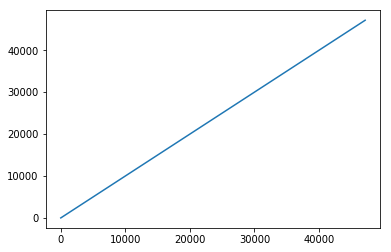

In [381]:
inertias = [] 

for n in range(1, 20):
    print(f'moving forward with {n}')
    kmeans = KMeans(n_clusters = n)
    
    km.fit(upsample_feat)
    inertias.append((n, km.inertia_))
    
plt.plot(inertias[0], inertias[1])
    

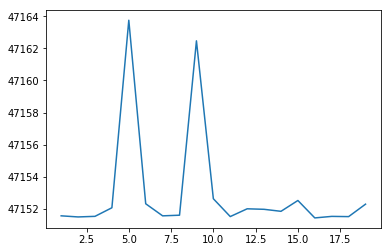

In [383]:
plt.plot([i[0] for i in inertias], [i[1] for i in inertias])

In [346]:
rfc.score(test_feat, np.array(y_test_short[:25000]))

0.55636

Definitely some improvement with word2vec! ~.56 ROC AUC!

In [287]:
pickle.dump(features, open('1k_features.pkl', 'wb'))
pickle.dump(response, open('1k_response.pkl', 'wb'))

## Clustering

In [300]:
km = KMeans()

rfc = RandomForestClassifier()

pipe = make_pipeline(km, rfc)

tuning_params = {'randomforestclassifier__n_estimators': [50, 100, 150, 200],
                 'kmeans__n_clusters': [i for i in range(1, 20)]}

gs = RandomizedSearchCV(pipe, tuning_params, cv=3, scoring='roc_auc')

gs.fit(features, response)

gs.best_score_

0.5159584307632196